In [1]:
import sys

sys.path.insert(0, sys.path[0].removesuffix("/src/nb"))
print(sys.path)

from ta.trend import *
from ta.momentum import *
from sklearn.model_selection import train_test_split
from pycaret.classification import ClassificationExperiment
from imblearn.under_sampling import AllKNN

import src.utils as utils
import src.myenv as myenv
import src.calc_utils as calc_utils

import pandas as pd
import numpy as np
import warnings

clustering = False
use_gpu = False
shuffle = True
categorical_features = None
train_size = 0.9

warnings.simplefilter("ignore")

['/home/marcelo/des/crypto_analysis_deep_learning', '/home/marcelo/des/crypto_analysis_deep_learning/src/nb', '/home/marcelo/miniconda3/envs/pycaret/lib/python311.zip', '/home/marcelo/miniconda3/envs/pycaret/lib/python3.11', '/home/marcelo/miniconda3/envs/pycaret/lib/python3.11/lib-dynload', '', '/home/marcelo/miniconda3/envs/pycaret/lib/python3.11/site-packages']


In [2]:
def setup_model(data, train_size = train_size, shuffle = shuffle, categorical_features = categorical_features, use_gpu = use_gpu):
    print(f'Setup Model: train_size: {train_size}, shuffle: {shuffle}, categorical_features: {categorical_features}, use_gpu: {use_gpu}')
    exp_class = ClassificationExperiment()
    exp_class = exp_class.setup(data, 
							train_size=train_size,
							data_split_shuffle=shuffle,
							data_split_stratify=shuffle,
							target='status',
							categorical_features=categorical_features,
							fix_imbalance=True, # repeatededitednearestneighbours instancehardnessthreshold allknn   
							fix_imbalance_method=AllKNN(allow_minority=False, kind_sel='all', n_jobs=-1, n_neighbors=3, sampling_strategy='auto'),
							#fix_imbalance_method=RepeatedEditedNearestNeighbours(kind_sel='all', max_iter=100, n_jobs=20, n_neighbors=3, sampling_strategy='auto'), 
							#fix_imbalance_method=InstanceHardnessThreshold(cv=5, estimator=None, n_jobs=20, random_state=123, sampling_strategy='auto'),                        
							#remove_outliers=True,
							#normalize=True, 
							#normalize_method='zscore', 
							#transformation=True,
							#transformation_method='yeo-johnson',
							#polynomial_features=True,
							session_id=123, 
							fold=3,	
							use_gpu=use_gpu)

    return exp_class

In [3]:
df = utils.get_database(
    symbol="BTCUSDT", interval="1h", columns=myenv.all_klines_cols, parse_dates=False
)
df.drop(
    columns=[
        "open_time",
        "close_time",
        "volume",
        "quote_asset_volume",
        "number_of_trades",
        "taker_buy_base_asset_volume",
        "taker_buy_quote_asset_volume",
        "ignore",
    ],
    inplace=True,
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58550 entries, 1502942400000 to 1714179600000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    58550 non-null  float32
 1   high    58550 non-null  float32
 2   low     58550 non-null  float32
 3   close   58550 non-null  float32
dtypes: float32(4)
memory usage: 1.3 MB


In [4]:
df = calc_utils.calc_ema_periods(
    df, [150, 200, 250, 300], close_price="close", diff_price=True
)
df = calc_utils.calc_RSI(
    df, close_price="close", window=14, fillna=False, last_one=False
)
df = calc_utils.calc_amplitude(df, column="close")

macd = MACD(df["close"], 12, 26, 9)
df["macd"] = macd.macd()
df["macd_diff"] = macd.macd_diff()
df["macd_signal"] = macd.macd_signal()

aoi = AwesomeOscillatorIndicator(df["high"], df["low"])
df["aoi"] = aoi.awesome_oscillator()

df["tsi"] = TSIIndicator(df["close"]).tsi()

df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58251 entries, 1504018800000 to 1714179600000
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            58251 non-null  float32
 1   high            58251 non-null  float32
 2   low             58251 non-null  float32
 3   close           58251 non-null  float32
 4   ema_150p        58251 non-null  float32
 5   ema_150p_diff   58251 non-null  float32
 6   ema_200p        58251 non-null  float32
 7   ema_200p_diff   58251 non-null  float32
 8   ema_250p        58251 non-null  float32
 9   ema_250p_diff   58251 non-null  float32
 10  ema_300p        58251 non-null  float32
 11  ema_300p_diff   58251 non-null  float32
 12  rsi             58251 non-null  float32
 13  amplitude       58251 non-null  float32
 14  amplitude_diff  58251 non-null  float32
 15  macd            58251 non-null  float64
 16  macd_diff       58251 non-null  float64
 17  macd_signal     

In [5]:
from pycaret.clustering import ClusteringExperiment

if clustering:
    categorical_features = ["Cluster"]
    exp = ClusteringExperiment()
    exp = exp.setup(
        df, normalize=True, normalize_method="minmax", session_id=123, use_gpu=use_gpu
    )
    model = exp.create_model("kmeans", num_clusters=4)
    df_cluster = exp.assign_model(model)
    df_cluster.info()
else:
    df_cluster = df

In [6]:
# plot pca cluster plot
if clustering:
    exp.plot_model(model, plot="cluster")

In [7]:
# plot elbow
if clustering:
    exp.plot_model(model, plot="elbow")

In [8]:
# plot silhouette
# exp.plot_model(model, plot = 'silhouette')

In [9]:
df_cluster["variation"] = (
    df_cluster["close"] - df_cluster["close"].shift(24)
) / df_cluster["close"]
df_cluster["status"] = np.where(
    df_cluster["variation"] > 0.015, "SOBE", "ESTAVEL"
)  # 1 == SOBE, 0 == ESTAVEL
df_cluster.dropna(inplace=True)
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58227 entries, 1504105200000 to 1714179600000
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            58227 non-null  float32
 1   high            58227 non-null  float32
 2   low             58227 non-null  float32
 3   close           58227 non-null  float32
 4   ema_150p        58227 non-null  float32
 5   ema_150p_diff   58227 non-null  float32
 6   ema_200p        58227 non-null  float32
 7   ema_200p_diff   58227 non-null  float32
 8   ema_250p        58227 non-null  float32
 9   ema_250p_diff   58227 non-null  float32
 10  ema_300p        58227 non-null  float32
 11  ema_300p_diff   58227 non-null  float32
 12  rsi             58227 non-null  float32
 13  amplitude       58227 non-null  float32
 14  amplitude_diff  58227 non-null  float32
 15  macd            58227 non-null  float64
 16  macd_diff       58227 non-null  float64
 17  macd_signal     

In [10]:
df_cluster.drop(columns=["variation"], inplace=True)
df_cluster["status"].value_counts()

status
ESTAVEL    42080
SOBE       16147
Name: count, dtype: int64

In [11]:
train_data, validation_data = train_test_split(
    df_cluster, train_size=train_size, random_state=123, shuffle=shuffle
)

In [12]:
exp_class = setup_model(train_data)

Setup Model: train_size: 0.9, shuffle: True, categorical_features: None, use_gpu: False


,Description,Value
0,Session id,123
1,Target,status
2,Target type,Binary
3,Target mapping,"ESTAVEL: 0, SOBE: 1"
4,Original data shape,"(52404, 21)"
5,Transformed data shape,"(47400, 21)"
6,Transformed train set shape,"(42159, 21)"
7,Transformed test set shape,"(5241, 21)"
8,Numeric features,20
9,Preprocess,True


In [13]:
"""
et	Extra Trees Classifier	0.9291	0.0000	0.9291	0.9284	0.9285	0.8199	0.8206	0.3350
rf	Random Forest Classifier	0.9265	0.0000	0.9265	0.9257	0.9259	0.8136	0.8141	1.0330
lightgbm	Light Gradient Boosting Machine	0.9198	0.0000	0.9198	0.9190	0.9192	0.7970	0.7974	0.4660
gbc	Gradient Boosting Classifier	0.9137	0.9661	0.9137	0.9128	0.9131	0.7816	0.7820	21.8550
ada	Ada Boost Classifier	0.9030	0.9595	0.9030	0.9022	0.9025	0.7553	0.7556	4.2980
lr	Logistic Regression	0.9012	0.9526	0.9012	0.8996	0.8993	0.7447	0.7471	0.2800
svm	SVM - Linear Kernel	0.9001	0.9506	0.9001	0.8988	0.8979	0.7406	0.7439	0.2090
knn	K Neighbors Classifier	0.8939	0.0000	0.8939	0.8921	0.8922	0.7269	0.7288	0.2160
dt	Decision Tree Classifier	0.8897	0.0000	0.8897	0.8901	0.8899	0.7255	0.7256	0.9880
lda	Linear Discriminant Analysis	0.8865	0.9477	0.8865	0.8846	0.8830	0.7011	0.7065	0.1990
ridge	Ridge Classifier	0.8811	0.9447	0.8811	0.8802	0.8760	0.6810	0.6908	0.1650
qda	Quadratic Discriminant Analysis	0.8547	0.9124	0.8547	0.8522	0.8528	0.6283	0.6296	0.1780
nb	Naive Bayes	0.8119	0.0000	0.8119	0.8239	0.8161	0.5536	0.5570	0.1260
dummy	Dummy Classifier	0.7229	0.0000	0.7229	0.5226	0.6067	0.0000	0.0000	0.1190
"""

# best_model = exp_class.compare_models()
best_model = exp_class.create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9115,0.0000,0.9115,0.9203,0.9135,0.7900,0.7953
1,0.9099,0.0000,0.9099,0.9187,0.9120,0.7863,0.7915
2,0.9104,0.0000,0.9104,0.9198,0.9125,0.7880,0.7937
Mean,0.9106,0.0000,0.9106,0.9196,0.9127,0.7881,0.7935
Std,0.0006,0.0000,0.0006,0.0007,0.0006,0.0015,0.0016


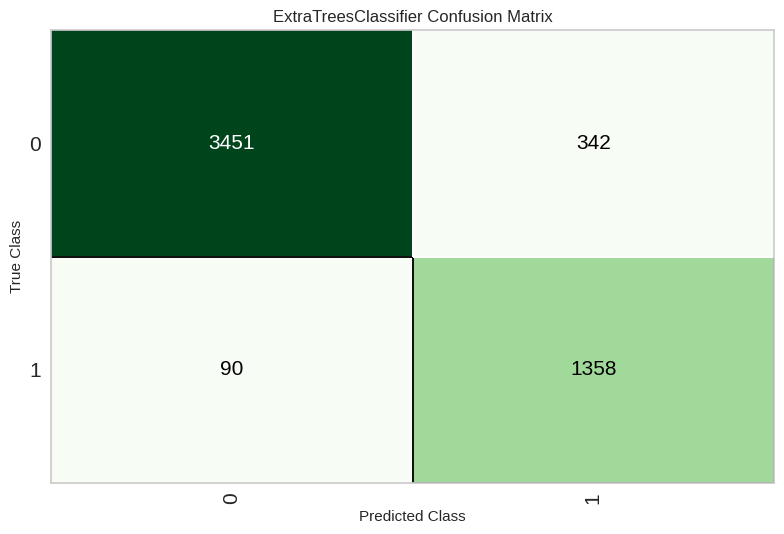

In [14]:
# plot confusion matrix
exp_class.plot_model(best_model, plot="confusion_matrix")

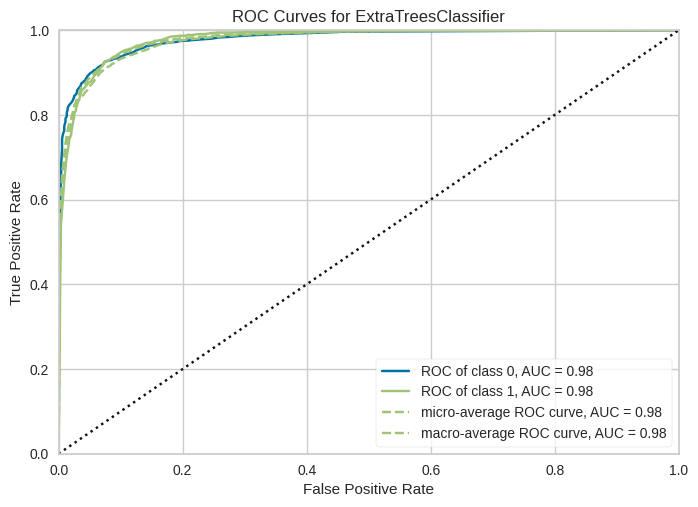

In [15]:
# plot AUC
exp_class.plot_model(best_model, plot="auc")

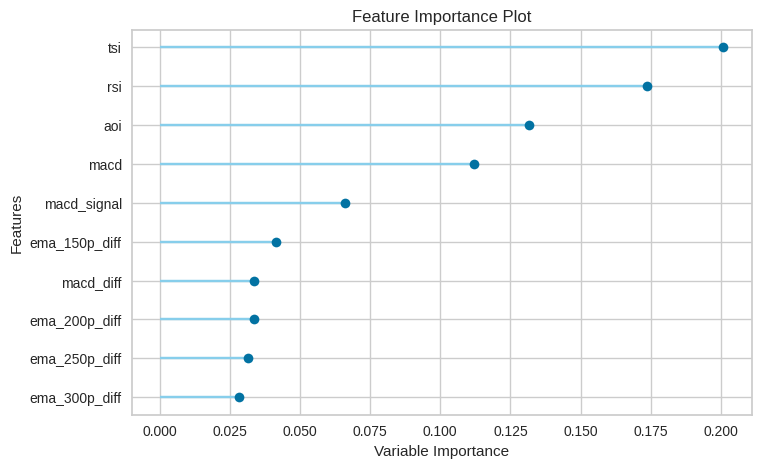

In [16]:
# plot feature importance
exp_class.plot_model(best_model, plot="feature")

In [17]:
# interpret summary model
# exp_class.interpret_model(best_model, plot = 'summary')

In [18]:
# reason plot for test set observation 1
# exp_class.interpret_model(best_model, plot = 'reason', observation = 1)

In [19]:
# exp_class.evaluate_model(best_model)

In [22]:
# tune hyperparameters of dt
tunned_model = best_model  # exp_class.tune_model(best_model)

In [23]:
# finalize model
final_model = exp_class.finalize_model(tunned_model)

In [24]:
# copy data and drop Class variable

new_data = validation_data.copy()
new_data.drop("status", axis=1, inplace=True)
# new_data.head()

In [25]:
# predict model on new_data
predictions = exp_class.predict_model(final_model, data=new_data)
# predictions.head()

In [26]:
predictions["status"] = validation_data["status"]
predictions["score"] = predictions["prediction_label"] == predictions["status"]

score_estavel = predictions[predictions["status"] == "ESTAVEL"]["score"].value_counts()
score_sobe = predictions[predictions["status"] == "SOBE"]["score"].value_counts()
score = predictions["score"].value_counts()

se = score_estavel[0] / (score_estavel[0] + score_estavel[1])
ss = score_sobe[0] / (score_sobe[0] + score_sobe[1])
s = score[0] / (score[0] + score[1])

print(f"Status: ESTAVEL: {se} - SOBE: {ss} - GERAL: {s}")

Status: ESTAVEL: 0.9148833854291897 - SOBE: 0.9405048076923077 - GERAL: 0.9222050489438434
